# Behavioral Modeling of a BSS123 MOSFET with Machine Learning

## Introduction:
This notebook attempts to create a machine learning model to predict the I-V characteristics of a BSS123 N-Channel MOSFET. The goal is to build a behavioral model that approximates the device's drain current ($I_{DS}$), using the gate-source voltage ($V_{GS}$) and drain-source voltage ($V_{DS}$) as input parameters.

## Workflow:
1. Modeling the device in LTSpice.
2. Sweeping through different values to create training and testing dataset
3. Exporting the raw data as text.
4. Parsing the raw simulation data, cleaning and then turning it into a usable pandas data frame.
5. Exploring the data obtained and visualizing the MOSFET's characteristic curves
6. Training and evaluating the data using various regression models
7. Analysing the result and attempting to derive an explicit equation from the model.

## LTspice Measurement Setup

![LTspice schematic showing a BSS123 N-channel MOSFET measurement circuit](images/mosfet_train.png "Figure: Circuit used to collect MOSFET data for training")

**Figure:** LTSpice schematic of the circuit used to generate the trainig dataset. Editable sources are available in `../sim/mosfet.asc` (schematic) and `../sim/mosfet.net` (netlist); the captured sweep is stored in `data/mosfet_train.txt`.


![LTspice schematic showing a BSS123 N-channel MOSFET measurement circuit](images/mosfet_test.png "Figure: Circuit used to collect MOSFET data for testing")

**Figure:** LTSpice schematic of the circuit used to generate the test dataset. Editable sources are available in `../sim/mosfet.asc` (schematic) and `../sim/mosfet.net` (netlist); the captured sweep is stored in `data/mosfet_test.txt`.

## 1. Parsing Data from LTSpice Output
- The raw text file is generated with LTSpice DC Sweep functionality. This file is semi-structured and not suitable to work with a model.
- The re library is thus used to parse through the data, identify step values of $V_{GS}$, then extract the corresponding $V_{DS}$ and $I_{DS}$ data from the table.
- The data is then compiled and stored in a CSV file for future use (if required)

In [162]:
import re
import pandas as pd

# Function to parse data from txt into usable pandas dataframe
def parse_txt(file_path):
    v_gs, v_ds, i_ds = [], [], []
    current_vgs = None

    with open(file_path, 'r') as file:
        for line in file:
            if 'Step Information: V_GS=' in line:
                match = re.search(r'V_GS=([0-9\.\-]+[munpkMG]?)', line)     #Searches for the phrase "V_GS={number}{unit}" in each line of file
                if match.group(1)[-1] in 'munpkMG':     #The following code lines add the necessary powers of the value if it contains units instead
                    current_vgs = float(match.group(1)[0:-1])
                    suffix = match.group(1)[-1]
                
                    if suffix == 'm':
                        current_vgs *= 1e-3
                    elif suffix == 'u':
                        current_vgs *= 1e-6
                    elif suffix == 'n':
                        current_vgs *= 1e-9
                    elif suffix == 'p':
                        current_vgs *= 1e-12
                    elif suffix == 'k':
                        current_vgs *= 1e3
                    elif suffix == 'M':
                        current_vgs *= 1e6
                    elif suffix == 'G':
                        current_vgs *= 1e9
                else:
                    current_vgs = float(match.group(1))
        
            elif ('\t' in line) and (current_vgs != None):
                try:
                    str_vds, str_ids = line.strip().split(sep='\t')
            
                    v_ds.append(float(str_vds))
                    i_ds.append(float(str_ids))
                    v_gs.append(current_vgs)
                except ValueError:
                    continue

    data = {'V_GS': v_gs, 'V_DS': v_ds, 'I_DS': i_ds}
    df_train = pd.DataFrame(data)
    return df_train

#Exporting data as csv for future use
mosfet_train = parse_txt(r'data/mosfet_train.txt')
mosfet_train.to_csv(r'data/mosfet_train.csv', index=False)

mosfet_test = parse_txt(r'data/mosfet_test.txt')
mosfet_test.to_csv(r'data/mosfet_test.txt', index=False)

## 2. Exploratory Data Analysis (EDA) & Visualization
Before moving on to training, the data is validated. By plotting the I-V curves, it is made sure that the data was parsed correctly and accurately represents the triode and saturation regions.

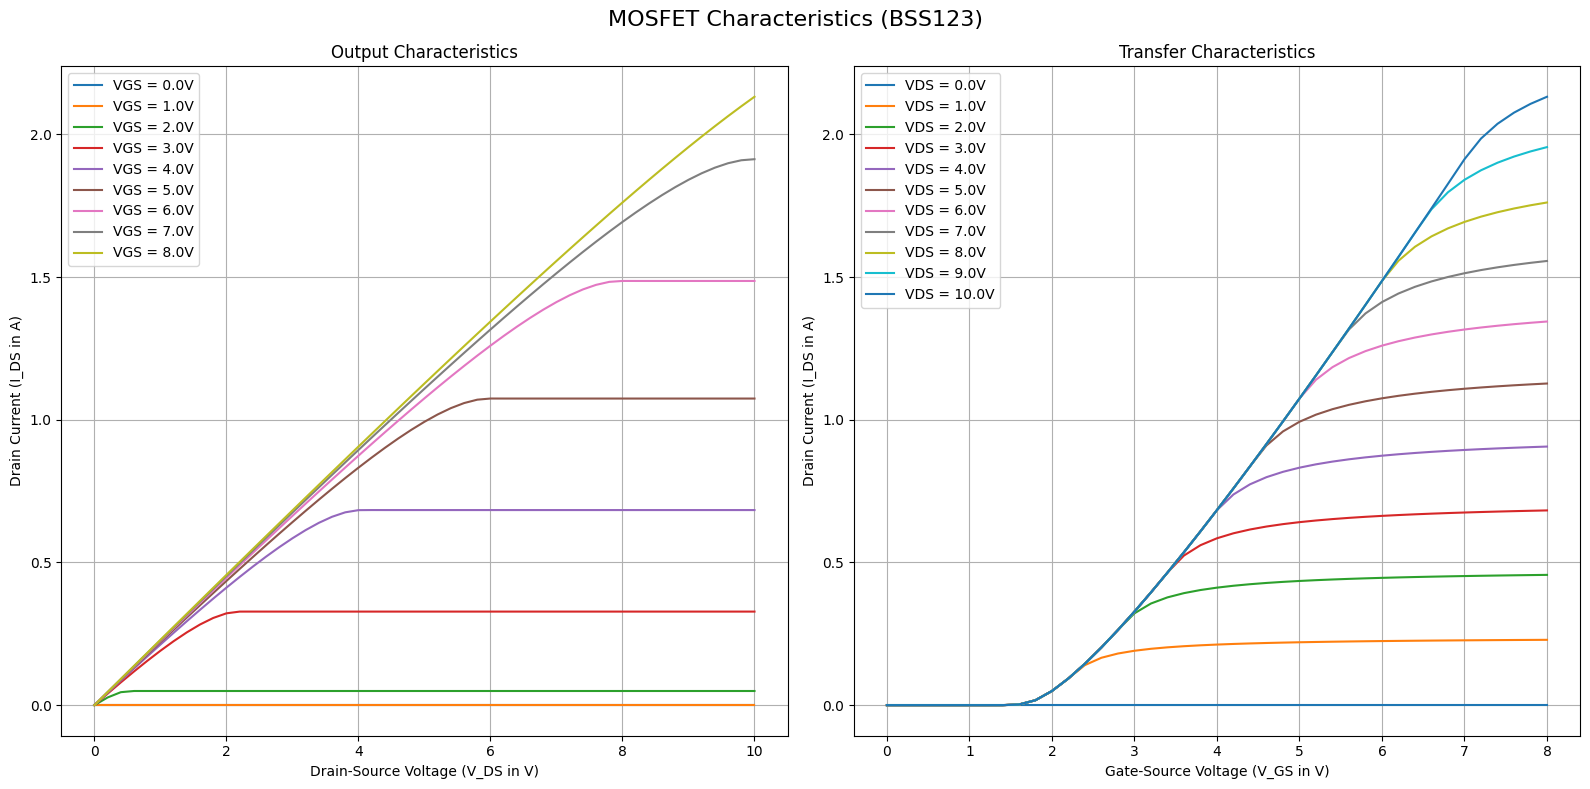

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# df = pd.read_csv(r'data/mosfet_data.csv')
df_train = pd.read_csv(r'data/mosfet_train.csv')

# Create figure with two subplots
plt.figure(figsize=(16, 8))

# Output characteristics: I_DS vs V_DS for different V_GS values
plt.subplot(1, 2, 1)
unique_vgs = sorted(df_train['V_GS'].unique())[::5]
for vgs in unique_vgs:
    subset = df_train[df_train['V_GS'] == vgs]
    plt.plot(subset['V_DS'], subset['I_DS'], label=f'VGS = {vgs}V')

plt.xlabel('Drain-Source Voltage (V_DS in V)')
plt.ylabel('Drain Current (I_DS in A)')
plt.title('Output Characteristics')
plt.grid(True)
plt.legend()

# Transfer characteristics: I_DS vs V_GS for selected V_DS values
plt.subplot(1, 2, 2)
unique_vds = sorted(df_train['V_DS'].unique())[::5]

# Selects a few representative V_DS values to avoid overcrowding
for vds in unique_vds:
    subset = df_train[df_train['V_DS'].round(2) == round(vds, 2)]
    plt.plot(subset['V_GS'], subset['I_DS'], label=f'VDS = {vds:.1f}V')

plt.xlabel('Gate-Source Voltage (V_GS in V)')
plt.ylabel('Drain Current (I_DS in A)')
plt.title('Transfer Characteristics')
plt.grid(True)
plt.legend()

plt.suptitle('MOSFET Characteristics (BSS123)', fontsize=16)
plt.tight_layout()
plt.show()

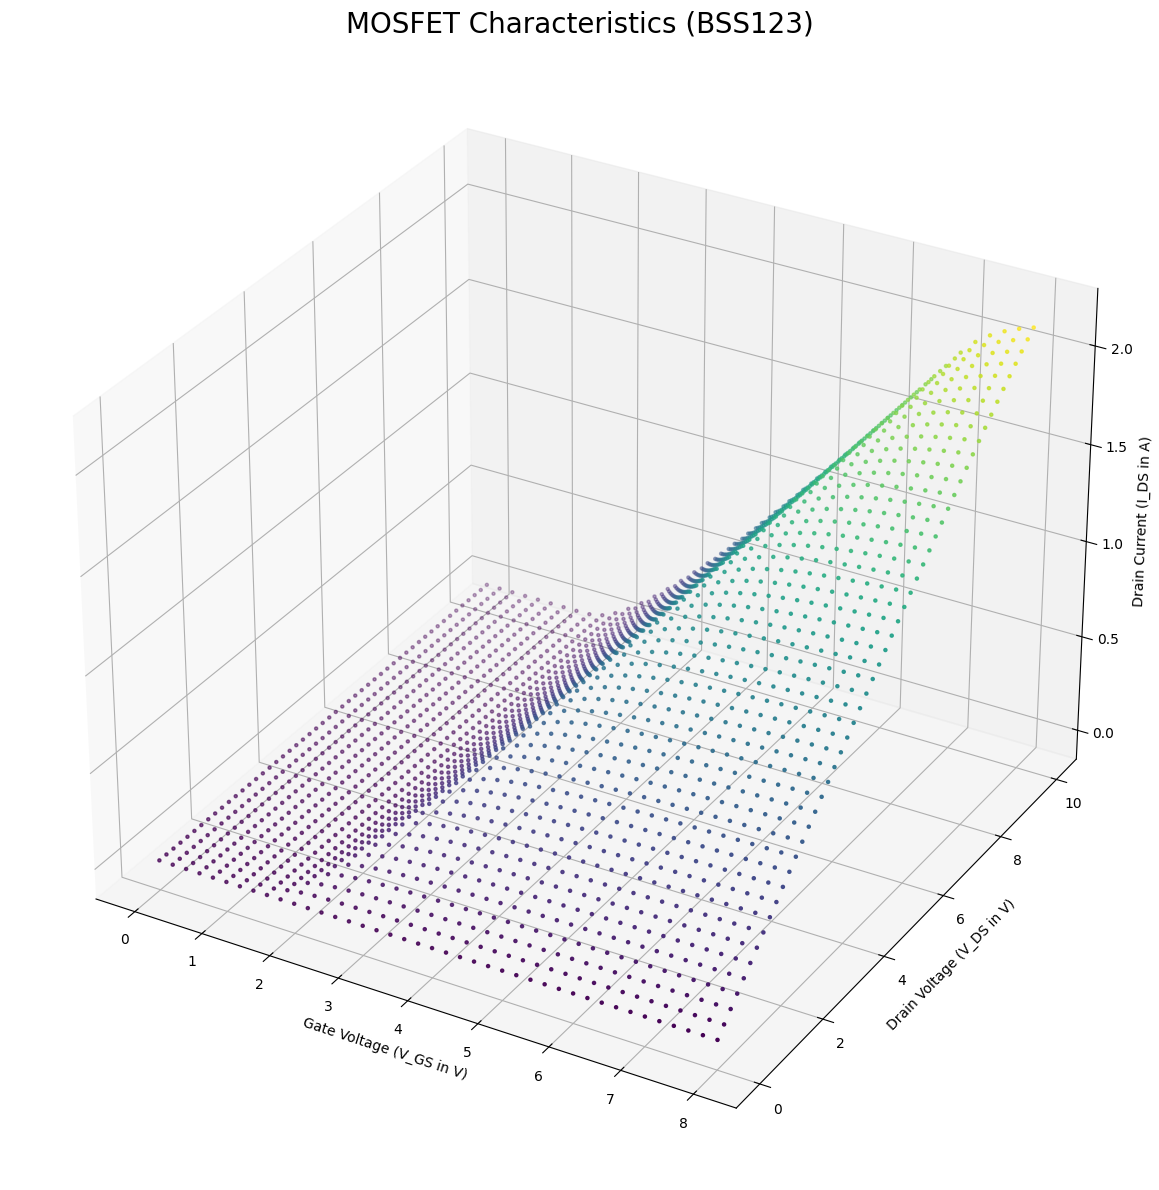

In [164]:
#3D plot showing Dependence of I_DS on both V_GS and V_DS
fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_train['V_GS'], df_train['V_DS'], df_train['I_DS'], cmap='viridis', c=df_train['I_DS'], marker='.')
ax.set_xlabel('Gate Voltage (V_GS in V)')
ax.set_ylabel('Drain Voltage (V_DS in V)')
ax.set_zlabel('Drain Current (I_DS in A)')
ax.set_title('MOSFET Characteristics (BSS123)',fontsize=20)

plt.tight_layout()
plt.show()

## 3. Data Splitting and Scaling
- The model is split into a 75% training set and 25% validation set.
- The Input Features ($V_{GS}$ and $V_{DS}$) are standardized using 'StandardScaler' to ensure both features contribute equally to the model's training process.

In [165]:
#Splitting data for Training and Testing (75:25)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_train[['V_GS', 'V_DS']]
y = df_train['I_DS']

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75, random_state=42, shuffle=True)   #Fixed random state to reproduce results

print(f'Shape of X_train : {X_train.shape}\tShape of X_val : {X_val.shape}')
print(f'Shape of y_train : {y_train.shape}\tShape of y_val : {y_val.shape}')

#Scaling Data to fit input between 0-1

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

Shape of X_train : (1568, 2)	Shape of X_val : (523, 2)
Shape of y_train : (1568,)	Shape of y_val : (523,)


## 4. The Machine Learning Models used: 

### 4.1 The Linear Regression Model

- While the Linear Model may not serve to be of much use in this analysis, it is helpful in proving that the relation between the input and output parameters is indeed non-linear, as seen by the low $R^2$ Score.
- In fact, the $R^2$ Score obtained serves as a baseline score to prove that other non-linear models do have improved predictions.

R2 Score: 0.7798
Mean Squared Error (MSE): 0.0666
Root Mean Squared Error (RMSE): 0.2580


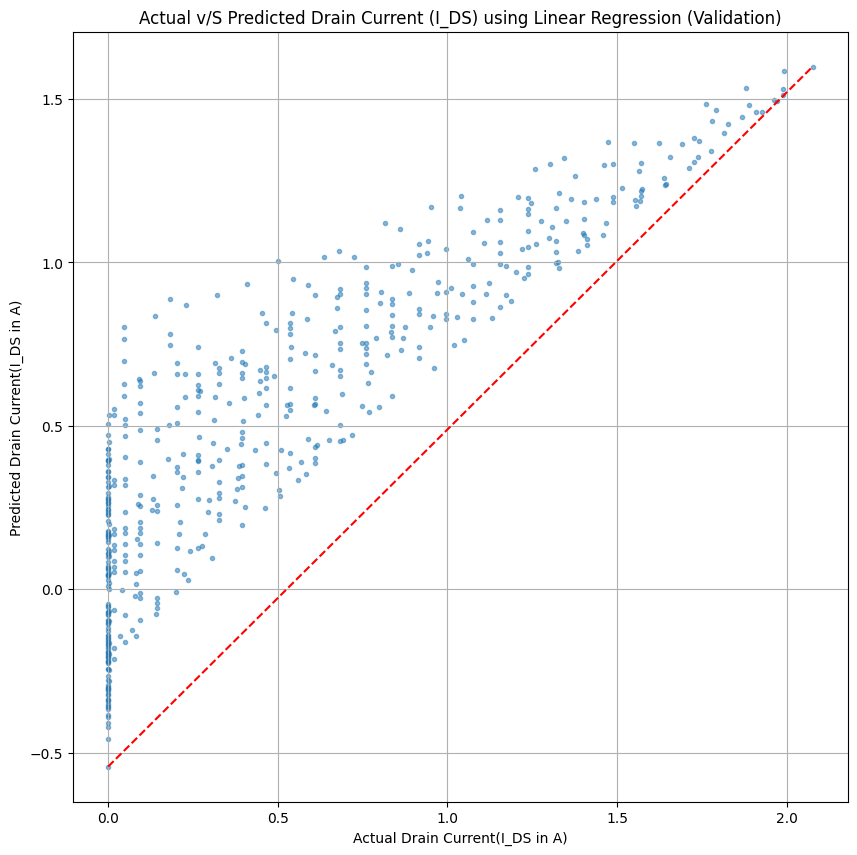

In [166]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
y_pred_linear = linear_model.predict(X_val_scaled)

r2_linear = r2_score(y_val, y_pred_linear)
mse_linear = mean_squared_error(y_val, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)

print(f'R2 Score: {r2_linear:.4f}')
print(f'Mean Squared Error (MSE): {mse_linear:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_linear:.4f}')

#Plotting Actual v/s Predicted Plot with a 45 degree line to show perfect prediction
plt.figure(figsize=(10, 10))
plt.scatter(y_val, y_pred_linear, alpha=0.5, marker='.')
plt.plot([y_val.min(), y_val.max()], [y_pred_linear.min(), y_pred_linear.max()], 'r--')
plt.xlabel('Actual Drain Current(I_DS in A)')
plt.ylabel('Predicted Drain Current(I_DS in A)')
plt.title('Actual v/S Predicted Drain Current (I_DS) using Linear Regression (Validation)')
plt.grid(True)
plt.show()

### 4.2. The Polynomial Regression Model (Degree = 2)
- Coming from the linear model, the polynomial model is used to train the data. The purpose is to find out if a rather simple, interpretable equation can capture the device's non-linear behavior. 
- This model allows us to extract the equation used, to examine the relationship between the features.
- The respectable $R^2$ Score shows the feasibility of the model.

Shape of polynomial features: (1568, 5)
R2 Score: 0.9517
Mean Squared Error (MSE): 0.0146
Root Mean Squared Error (RMSE): 0.1209


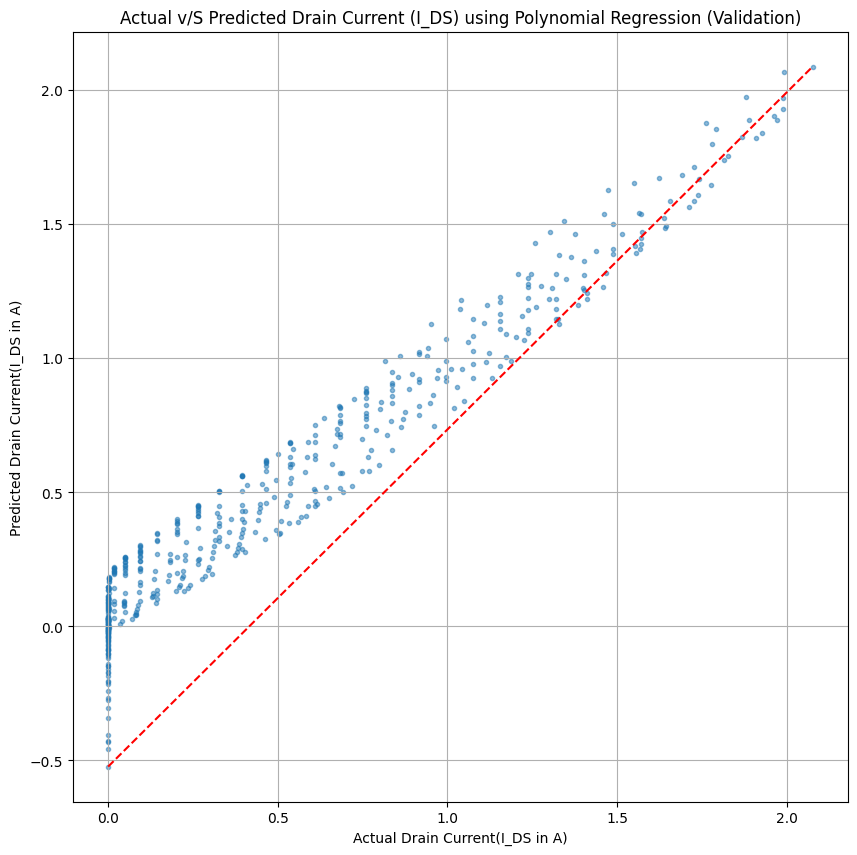

In [187]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)

X_train_poly = poly.fit_transform(X_train_scaled)
X_val_poly = poly.transform(X_val_scaled)

print(f'Shape of polynomial features: {X_train_poly.shape}')

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

y_pred_poly = poly_model.predict(X_val_poly)

r2_poly = r2_score(y_val, y_pred_poly)
mse_poly = mean_squared_error(y_val, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)

print(f'R2 Score: {r2_poly:.4f}')
print(f'Mean Squared Error (MSE): {mse_poly:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_poly:.4f}')

plt.figure(figsize=(10, 10))
plt.scatter(y_val, y_pred_poly, alpha=0.5, marker='.')
plt.plot([y_val.min(), y_val.max()], [y_pred_poly.min(), y_pred_poly.max()], 'r--')
plt.xlabel('Actual Drain Current(I_DS in A)')
plt.ylabel('Predicted Drain Current(I_DS in A)')
plt.title('Actual v/S Predicted Drain Current (I_DS) using Polynomial Regression (Validation)')
plt.grid(True)
plt.show()


In [197]:
#Extracting the equation from the model

feature_names = poly.get_feature_names_out(['V_GS', 'V_DS'])
coefficients = poly_model.coef_

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficients': coefficients})
print(f'Coefficients and Features used : {coef_df.head(10)}')

intercept = poly_model.intercept_
print(f"\nIntercept: {intercept}")

equation = f"I_DS = {intercept:.6e}"
for feat, coef in zip(feature_names, coefficients):
    if abs(coef) > 1e-10:
        equation += f' + ({coef:.6e} * {feat})'
print(f'\n===Full equation===\n\n{equation}')

Coefficients and Features used :      Feature  Coefficients
0       V_GS      0.414181
1       V_DS      0.245269
2     V_GS^2     -0.001197
3  V_GS V_DS      0.231297
4     V_DS^2     -0.067076

Intercept: 0.6095052159495625

===Full equation===

I_DS = 6.095052e-01 + (4.141809e-01 * V_GS) + (2.452691e-01 * V_DS) + (-1.197138e-03 * V_GS^2) + (2.312969e-01 * V_GS V_DS) + (-6.707601e-02 * V_DS^2)


### 4.3. The Random Forest Regression Model
- An ensemble model known for its high performance and ability to capture complex interactions without any explicit feature-engineering. 
- It is a highly accurate model based on Decision Tree, thus extracting an equation from this model is impossible.
- The near perfect $R^2$ Score shows this to be the best performer.

R2 Score: 0.9999
Mean Squared Error (MSE): 0.000021
Root Mean Squared Error (RMSE): 0.0046


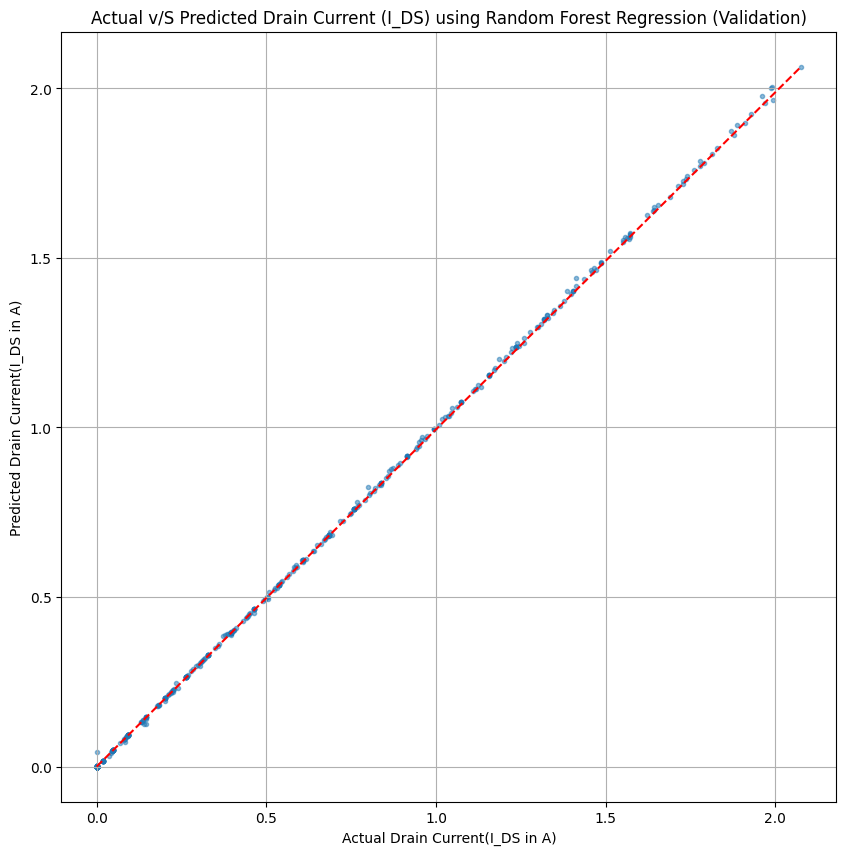

In [189]:

from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_val_scaled)

r2_rf = r2_score(y_val, y_pred_rf)
mse_rf = mean_squared_error(y_val, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print(f'R2 Score: {r2_rf:.4f}')
print(f'Mean Squared Error (MSE): {mse_rf:.6f}')
print(f'Root Mean Squared Error (RMSE): {rmse_rf:.4f}')

plt.figure(figsize=(10, 10))
plt.scatter(y_val, y_pred_rf, alpha=0.5, marker='.')
plt.plot([y_val.min(), y_val.max()], [y_pred_rf.min(), y_pred_rf.max()], 'r--')
plt.xlabel('Actual Drain Current(I_DS in A)')
plt.ylabel('Predicted Drain Current(I_DS in A)')
plt.title('Actual v/S Predicted Drain Current (I_DS) using Random Forest Regression (Validation)')
plt.grid(True)
plt.show()

## 5. Model Evaluation and Analysis

### 5.1 Validation Results Summary

After training three different models on the BSS123 MOSFET data, here's what I learned from the validation set:

| Model | R² Score | MSE | RMSE | Key Insights |
|-------|----------|-----|------|--------------|
| Linear Regression | 0.7798 | 0.0666 | 0.2580 | Baseline model; confirms non-linear behavior |
| Polynomial (deg=2) | 0.9517 | 0.0146 | 0.1209 | Good balance of accuracy and interpretability |
| Random Forest | 0.9999 | 0.000021 | 0.0046 | Near-perfect fit on validation; potential overfitting concern |

**Key Learnings from Validation:**

1. **Linear Model Limitations**: The R² of 0.77 confirms that MOSFET behavior is inherently non-linear and cannot be captured by simple linear relationships.

2. **Polynomial Model Success**: The degree-2 polynomial achieved R² = 0.9517, successfully capturing:
   - Triode region behavior (linear V_DS dependence)
   - Saturation region behavior (V_DS independence)

3. **Random Forest Performance**: The near-perfect R² = 0.9999 on validation data is suspiciously good and raises concerns:
   - May indicate overfitting to training data patterns
   - Tree-based models struggle with extrapolation beyond training ranges
   - Not suitable for true behavioral modeling despite high accuracy
   - A mathematical equation cannot be extracted

### 5.2 Extracted Mathematical Model

The polynomial regression yielded an interpretable equation:

$$I_{DS} = 0.609 + 0.414 V_{GS} + 0.245 V_{DS} - 0.001 V_{GS}^2 + 0.231 V_{GS}V_{DS} - 0.067 V_{DS}^2$$

**Physical Interpretation:**
- **Positive linear terms** ($V_{GS}$, $V_{DS}$): Basic transistor on-resistance
- **Negative $V_{GS}^2$ term**: Mobility degradation at high gate fields  
- **Positive $V_{GS} \cdot V_{DS}$ term**: Channel modulation effect
- **Negative $V_{DS}^2$ term**: Captures transition to saturation


## 6. Test Set Evaluation

Now I evaluate all models on completely unseen test data to assess true generalization capability.

### 6.1 Test Data Characteristics

In [190]:
#Importing test data
df_test = pd.read_csv(r'data/mosfet_test.csv')

X_test = df_test[['V_GS', 'V_DS']]
y_test = df_test['I_DS']

#Scaling test data with test parameters
X_test_scaled = scaler.transform(X_test)

R2 Score: 0.3859
Mean Squared Error (MSE): 0.2571
Root Mean Squared Error (RMSE): 0.5071


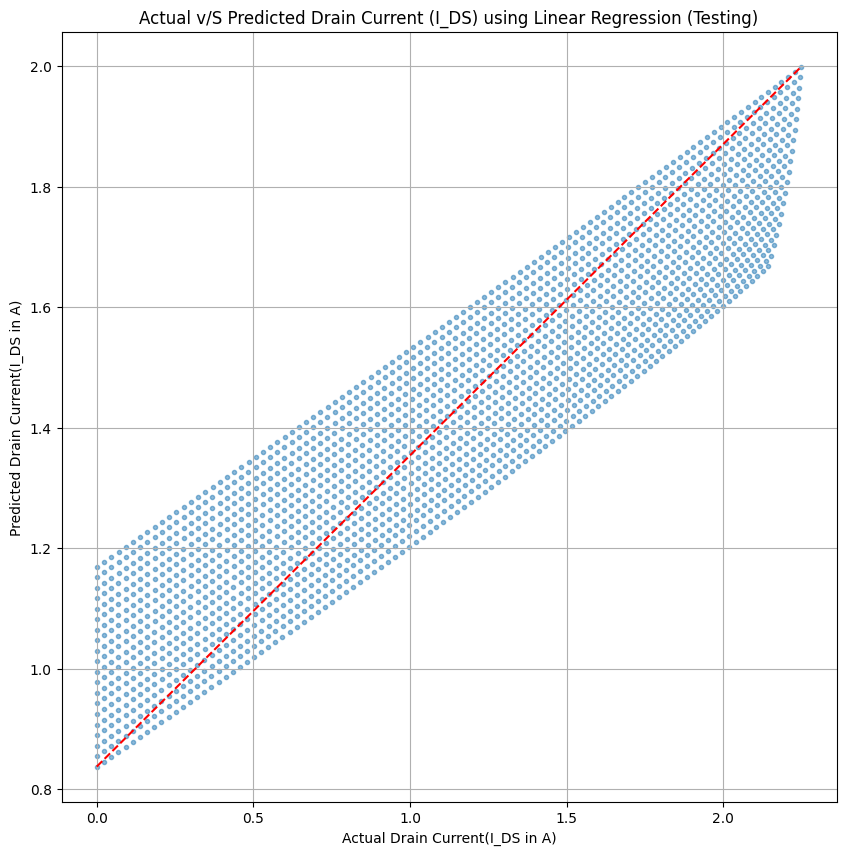

In [191]:
#Using Linear Regression

y_pred_linear = linear_model.predict(X_test_scaled)

r2_linear = r2_score(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)

print(f'R2 Score: {r2_linear:.4f}')
print(f'Mean Squared Error (MSE): {mse_linear:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_linear:.4f}')

#Plotting Actual v/s Predicted Plot with a 45 degree line to show perfect prediction
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred_linear, alpha=0.5, marker='.')
plt.plot([y_test.min(), y_test.max()], [y_pred_linear.min(), y_pred_linear.max()], 'r--')
plt.xlabel('Actual Drain Current(I_DS in A)')
plt.ylabel('Predicted Drain Current(I_DS in A)')
plt.title('Actual v/S Predicted Drain Current (I_DS) using Linear Regression (Testing)')
plt.grid(True)
plt.show()

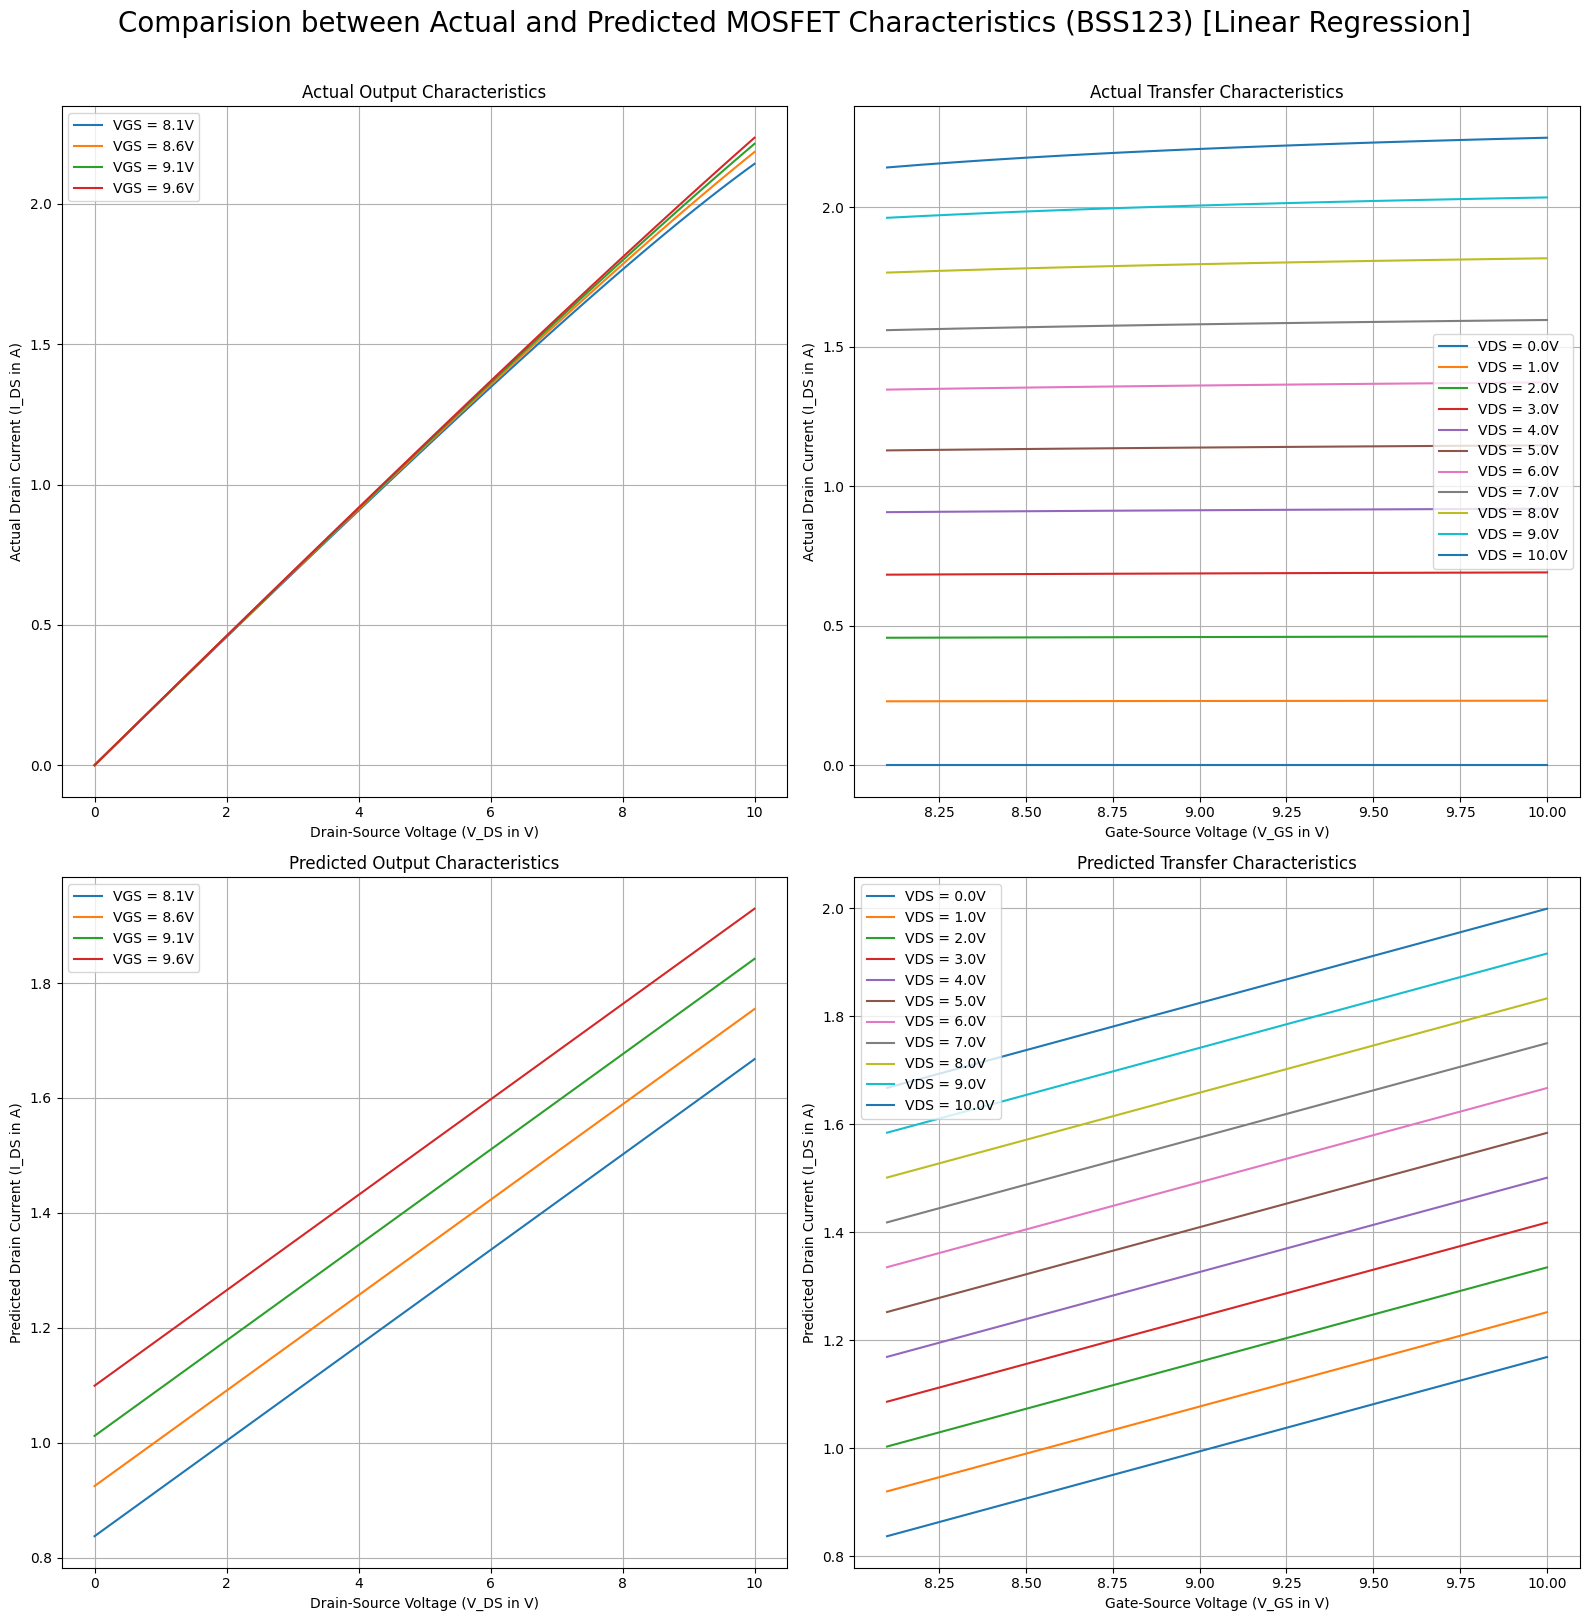

In [192]:
# Plotting Comparision results between Actual and Predicted Data

df_pred_linear = df_test[['V_GS', 'V_DS']].copy()
df_pred_linear['I_DS'] = y_pred_linear

# Create figure with two subplots
plt.figure(figsize=(16, 16))

# Actual Output characteristics: I_DS vs V_DS for different V_GS values
plt.subplot(2, 2, 1)
unique_vgs = sorted(df_test['V_GS'].unique())[::5]
for vgs in unique_vgs:
    subset = df_test[df_test['V_GS'] == vgs]
    plt.plot(subset['V_DS'], subset['I_DS'], label=f'VGS = {vgs}V')

plt.xlabel('Drain-Source Voltage (V_DS in V)')
plt.ylabel('Actual Drain Current (I_DS in A)')
plt.title('Actual Output Characteristics')
plt.grid(True)
plt.legend()

# Actual Transfer characteristics: I_DS vs V_GS for selected V_DS values
plt.subplot(2, 2, 2)
unique_vds = sorted(df_test['V_DS'].unique())[::10]

# Selects a few representative V_DS values to avoid overcrowding
for vds in unique_vds:
    subset = df_test[df_test['V_DS'].round(2) == round(vds, 2)]
    plt.plot(subset['V_GS'], subset['I_DS'], label=f'VDS = {vds:.1f}V')

plt.xlabel('Gate-Source Voltage (V_GS in V)')
plt.ylabel('Actual Drain Current (I_DS in A)')
plt.title('Actual Transfer Characteristics')
plt.grid(True)
plt.legend()

# Predicted Output characteristics: I_DS vs V_DS for different V_GS values
plt.subplot(2, 2, 3)
unique_vgs = sorted(df_pred_linear['V_GS'].unique())[::5]
for vgs in unique_vgs:
    subset = df_pred_linear[df_pred_linear['V_GS'] == vgs]
    plt.plot(subset['V_DS'], subset['I_DS'], label=f'VGS = {vgs}V')

plt.xlabel('Drain-Source Voltage (V_DS in V)')
plt.ylabel('Predicted Drain Current (I_DS in A)')
plt.title('Predicted Output Characteristics')
plt.grid(True)
plt.legend()

# Predicted Transfer characteristics: I_DS vs V_GS for selected V_DS values
plt.subplot(2, 2, 4)
unique_vds = sorted(df_pred_linear['V_DS'].unique())[::10]

# Selects a few representative V_DS values to avoid overcrowding
for vds in unique_vds:
    subset = df_pred_linear[df_pred_linear['V_DS'].round(2) == round(vds, 2)]
    plt.plot(subset['V_GS'], subset['I_DS'], label=f'VDS = {vds:.1f}V')

plt.xlabel('Gate-Source Voltage (V_GS in V)')
plt.ylabel('Predicted Drain Current (I_DS in A)')
plt.title('Predicted Transfer Characteristics')
plt.grid(True)
plt.legend()


plt.suptitle('Comparision between Actual and Predicted MOSFET Characteristics (BSS123) [Linear Regression]', fontsize=20, y=1.01)
plt.tight_layout()
plt.show()

R2 Score: 0.7485
Mean Squared Error (MSE): 0.1053
Root Mean Squared Error (RMSE): 0.3245


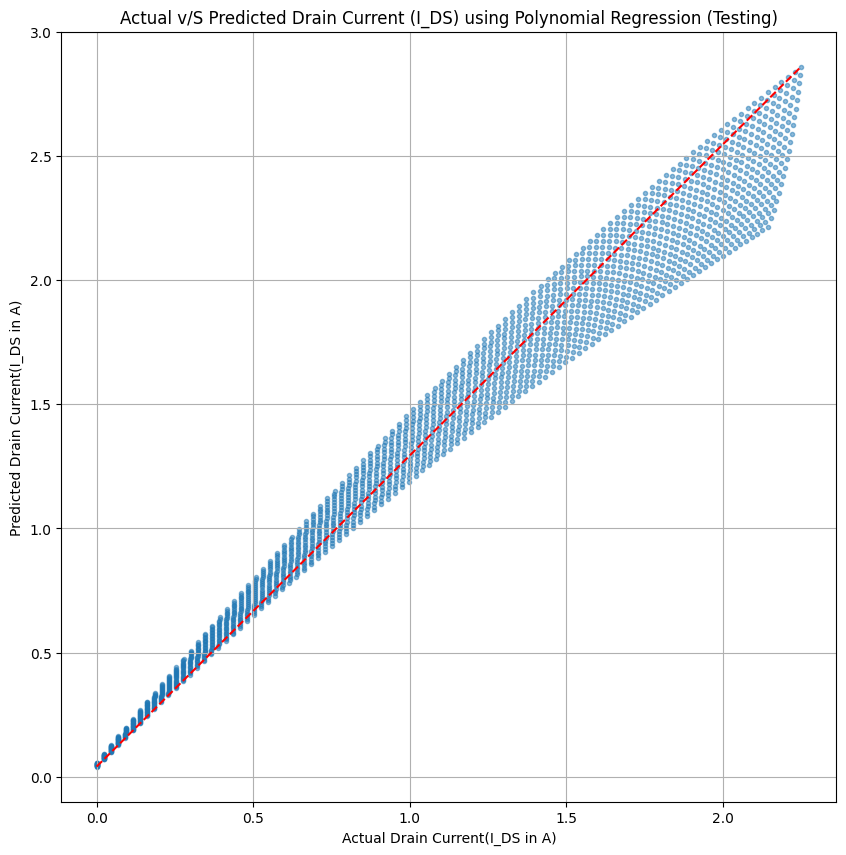

In [193]:
#Using Polynomial Regression

X_test_poly = poly.transform(X_test_scaled)
y_pred_poly = poly_model.predict(X_test_poly)

r2_poly = r2_score(y_test, y_pred_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)

print(f'R2 Score: {r2_poly:.4f}')
print(f'Mean Squared Error (MSE): {mse_poly:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_poly:.4f}')

plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred_poly, alpha=0.5, marker='.')
plt.plot([y_test.min(), y_test.max()], [y_pred_poly.min(), y_pred_poly.max()], 'r--')
plt.xlabel('Actual Drain Current(I_DS in A)')
plt.ylabel('Predicted Drain Current(I_DS in A)')
plt.title('Actual v/S Predicted Drain Current (I_DS) using Polynomial Regression (Testing)')
plt.grid(True)
plt.show()

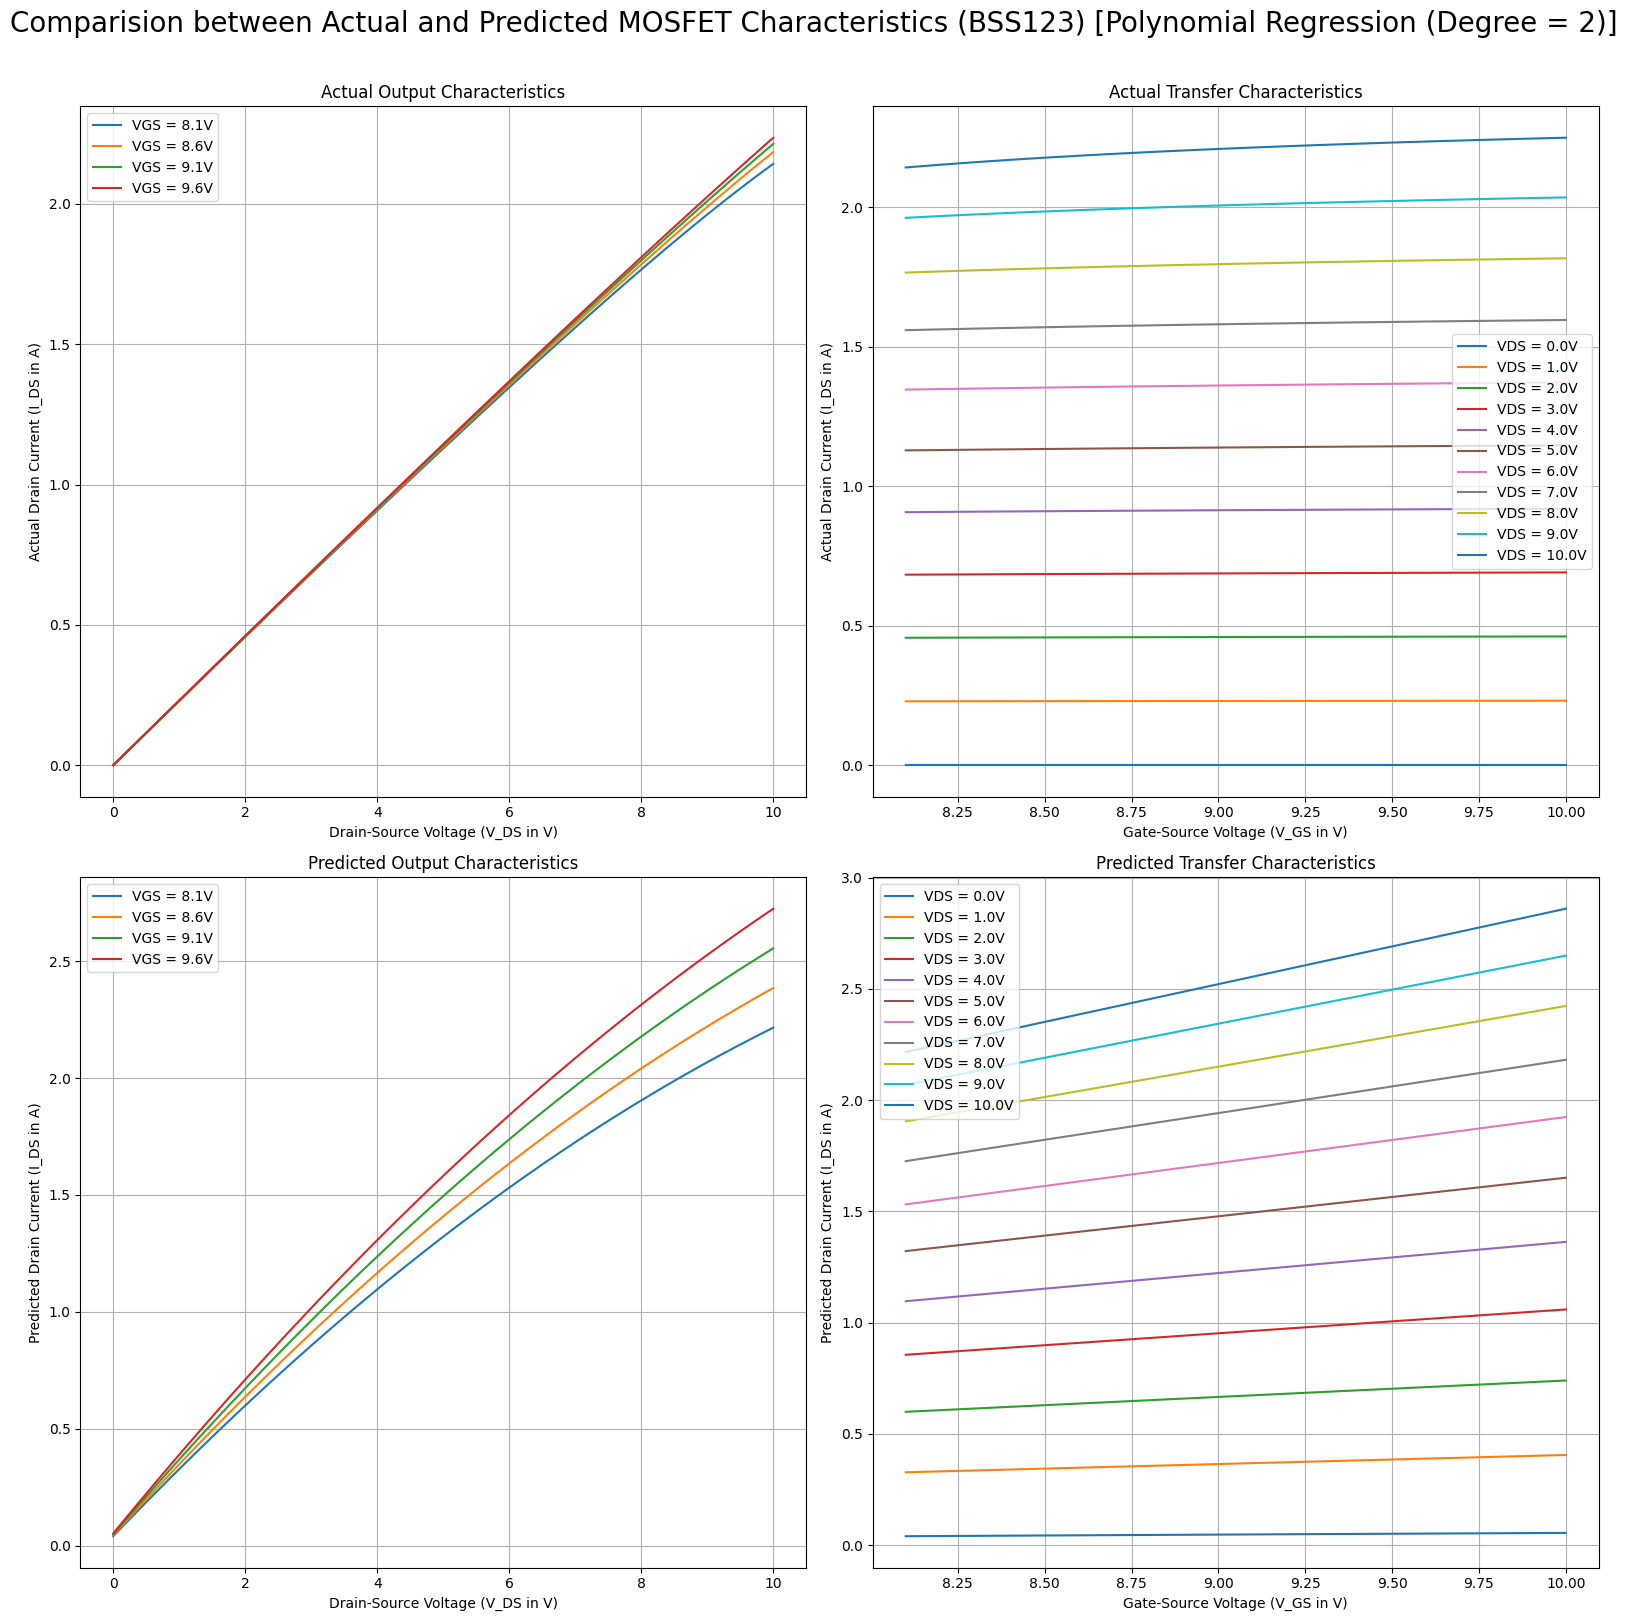

In [194]:
# Plotting Comparision results between Actual and Predicted Data

df_pred_polynomial = df_test[['V_GS', 'V_DS']].copy()
df_pred_polynomial['I_DS'] = y_pred_poly

# Create figure with two subplots
plt.figure(figsize=(16, 16))

# Actual Output characteristics: I_DS vs V_DS for different V_GS values
plt.subplot(2, 2, 1)
unique_vgs = sorted(df_test['V_GS'].unique())[::5]
for vgs in unique_vgs:
    subset = df_test[df_test['V_GS'] == vgs]
    plt.plot(subset['V_DS'], subset['I_DS'], label=f'VGS = {vgs}V')

plt.xlabel('Drain-Source Voltage (V_DS in V)')
plt.ylabel('Actual Drain Current (I_DS in A)')
plt.title('Actual Output Characteristics')
plt.grid(True)
plt.legend()

# Actual Transfer characteristics: I_DS vs V_GS for selected V_DS values
plt.subplot(2, 2, 2)
unique_vds = sorted(df_test['V_DS'].unique())[::10]

# Selects a few representative V_DS values to avoid overcrowding
for vds in unique_vds:
    subset = df_test[df_test['V_DS'].round(2) == round(vds, 2)]
    plt.plot(subset['V_GS'], subset['I_DS'], label=f'VDS = {vds:.1f}V')

plt.xlabel('Gate-Source Voltage (V_GS in V)')
plt.ylabel('Actual Drain Current (I_DS in A)')
plt.title('Actual Transfer Characteristics')
plt.grid(True)
plt.legend()

# Predicted Output characteristics: I_DS vs V_DS for different V_GS values
plt.subplot(2, 2, 3)
unique_vgs = sorted(df_pred_polynomial['V_GS'].unique())[::5]
for vgs in unique_vgs:
    subset = df_pred_polynomial[df_pred_polynomial['V_GS'] == vgs]
    plt.plot(subset['V_DS'], subset['I_DS'], label=f'VGS = {vgs}V')

plt.xlabel('Drain-Source Voltage (V_DS in V)')
plt.ylabel('Predicted Drain Current (I_DS in A)')
plt.title('Predicted Output Characteristics')
plt.grid(True)
plt.legend()

# Predicted Transfer characteristics: I_DS vs V_GS for selected V_DS values
plt.subplot(2, 2, 4)
unique_vds = sorted(df_pred_polynomial['V_DS'].unique())[::10]

# Selects a few representative V_DS values to avoid overcrowding
for vds in unique_vds:
    subset = df_pred_polynomial[df_pred_polynomial['V_DS'].round(2) == round(vds, 2)]
    plt.plot(subset['V_GS'], subset['I_DS'], label=f'VDS = {vds:.1f}V')

plt.xlabel('Gate-Source Voltage (V_GS in V)')
plt.ylabel('Predicted Drain Current (I_DS in A)')
plt.title('Predicted Transfer Characteristics')
plt.grid(True)
plt.legend()


plt.suptitle('Comparision between Actual and Predicted MOSFET Characteristics (BSS123) [Polynomial Regression (Degree = 2)]', fontsize=20, y=1.01)
plt.tight_layout()
plt.show()

R2 Score: 0.9957
Mean Squared Error (MSE): 0.001787
Root Mean Squared Error (RMSE): 0.0423


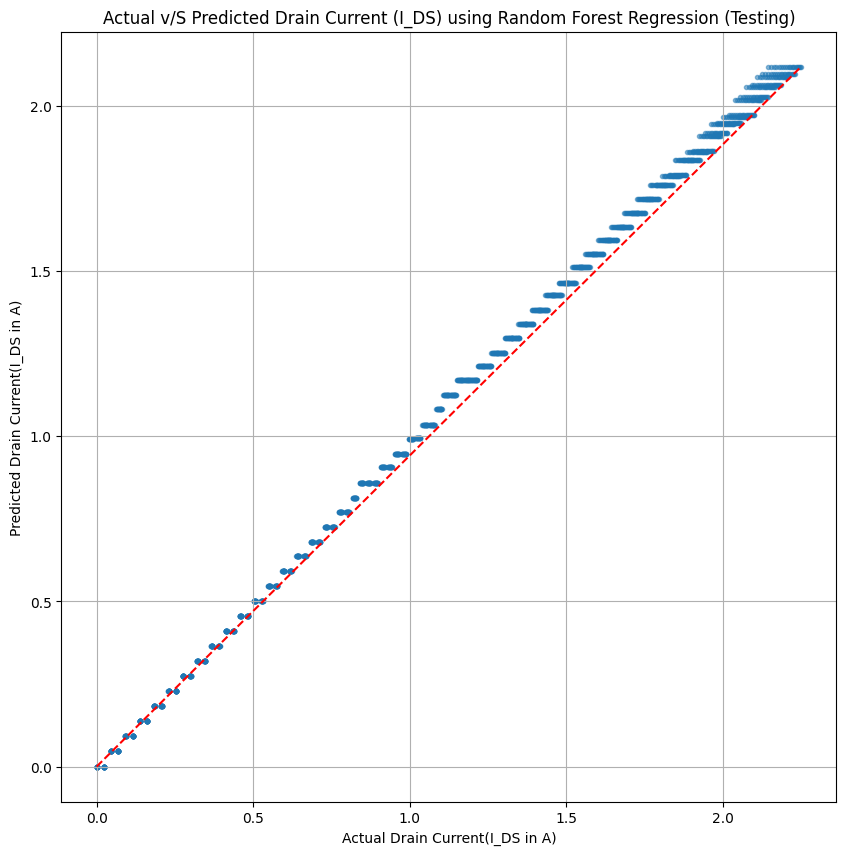

In [195]:
#Using Random Forest Regression

y_pred_rf = rf_model.predict(X_test_scaled)

r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print(f'R2 Score: {r2_rf:.4f}')
print(f'Mean Squared Error (MSE): {mse_rf:.6f}')
print(f'Root Mean Squared Error (RMSE): {rmse_rf:.4f}')

plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred_rf, alpha=0.5, marker='.')
plt.plot([y_test.min(), y_test.max()], [y_pred_rf.min(), y_pred_rf.max()], 'r--')
plt.xlabel('Actual Drain Current(I_DS in A)')
plt.ylabel('Predicted Drain Current(I_DS in A)')
plt.title('Actual v/S Predicted Drain Current (I_DS) using Random Forest Regression (Testing)')
plt.grid(True)
plt.show()

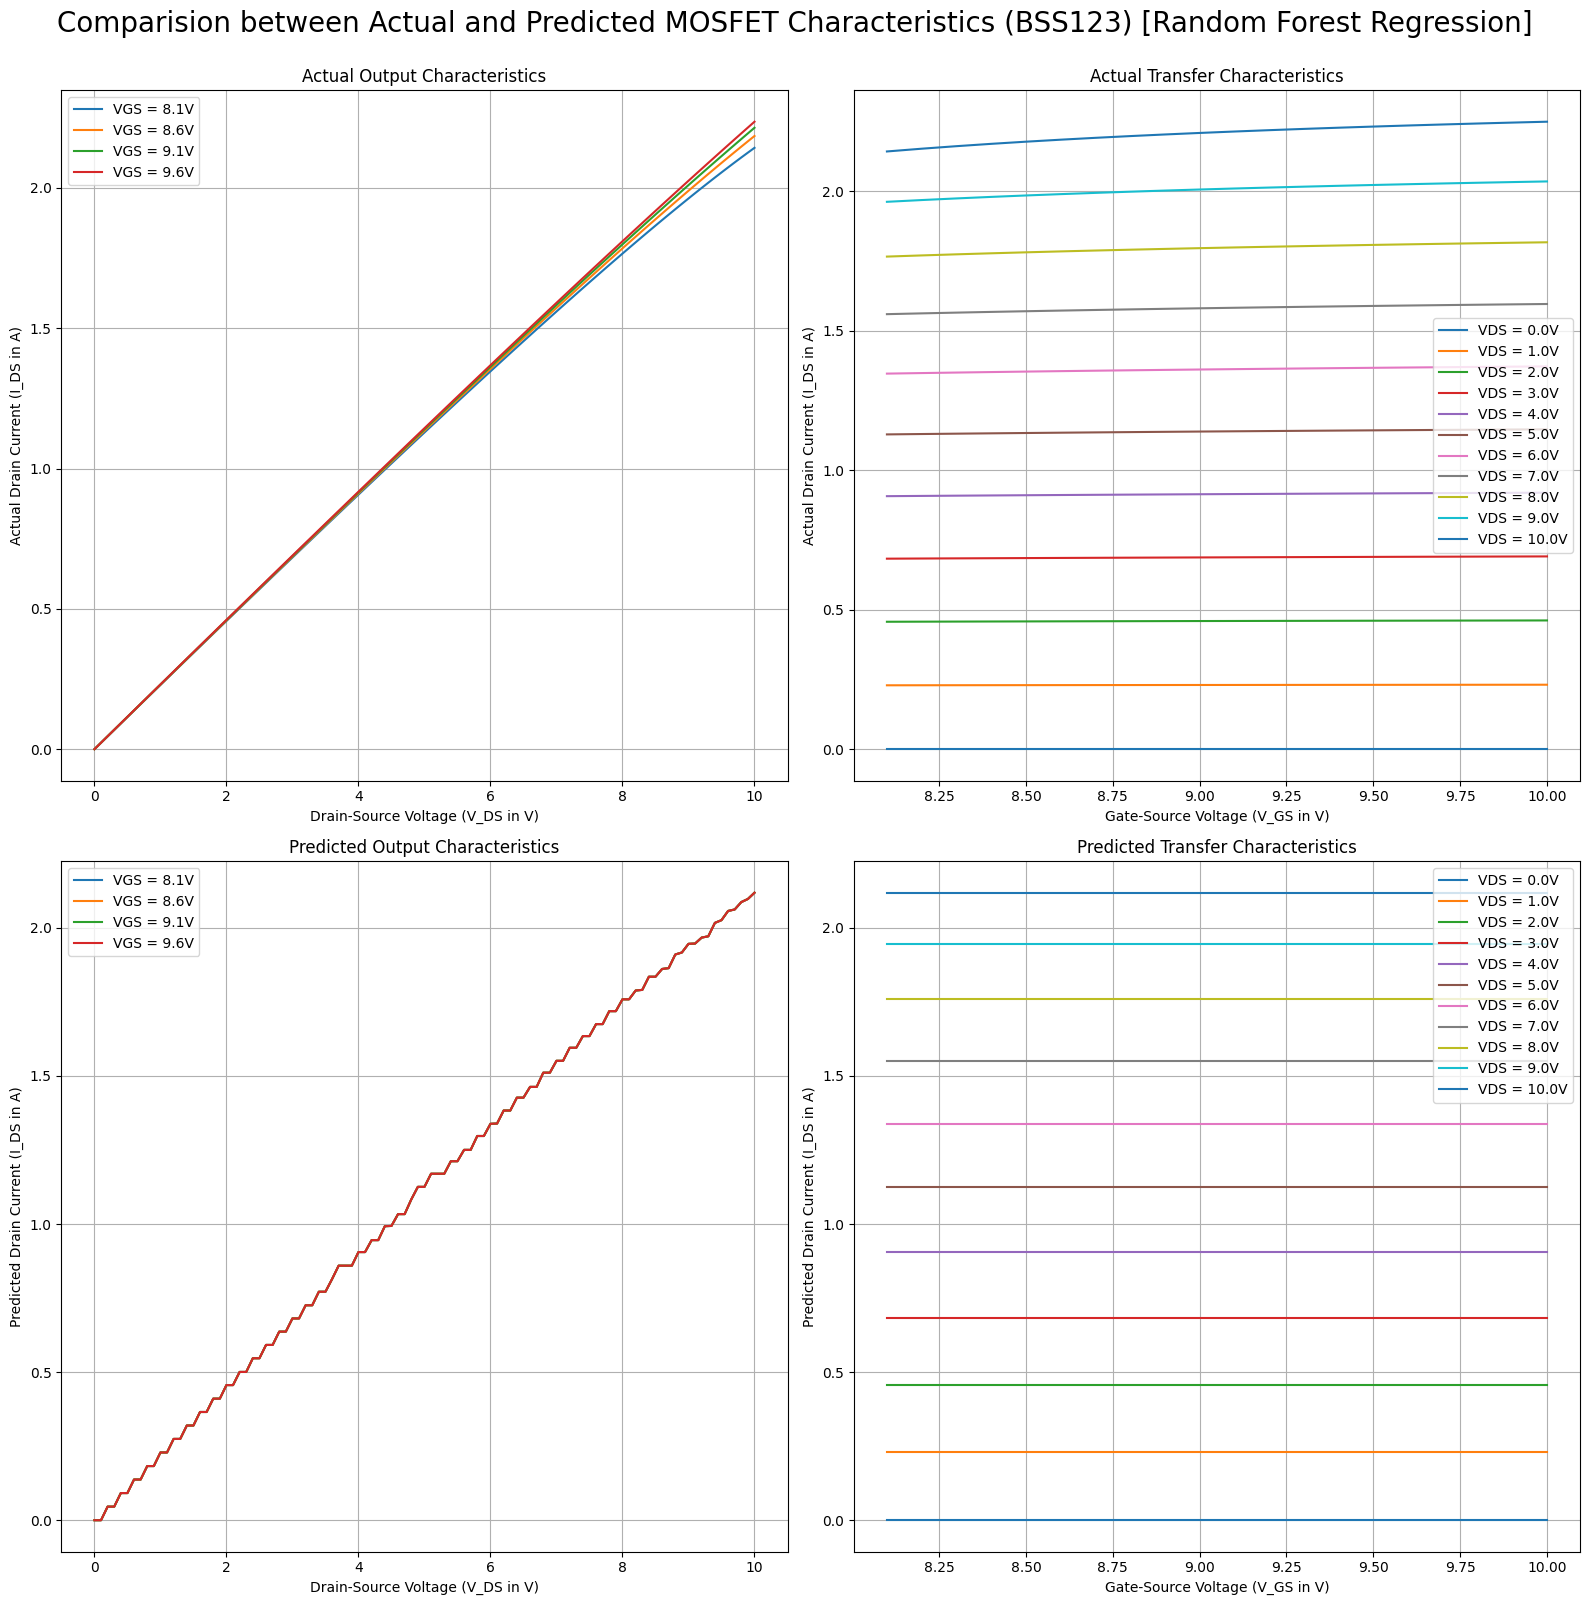

In [196]:
# Plotting Comparision results between Actual and Predicted Data

df_pred_forest = df_test[['V_GS', 'V_DS']].copy()
df_pred_forest['I_DS'] = y_pred_rf

# Create figure with two subplots
plt.figure(figsize=(16, 16))

# Actual Output characteristics: I_DS vs V_DS for different V_GS values
plt.subplot(2, 2, 1)
unique_vgs = sorted(df_test['V_GS'].unique())[::5]
for vgs in unique_vgs:
    subset = df_test[df_test['V_GS'] == vgs]
    plt.plot(subset['V_DS'], subset['I_DS'], label=f'VGS = {vgs}V')

plt.xlabel('Drain-Source Voltage (V_DS in V)')
plt.ylabel('Actual Drain Current (I_DS in A)')
plt.title('Actual Output Characteristics')
plt.grid(True)
plt.legend()

# Actual Transfer characteristics: I_DS vs V_GS for selected V_DS values
plt.subplot(2, 2, 2)
unique_vds = sorted(df_test['V_DS'].unique())[::10]

# Selects a few representative V_DS values to avoid overcrowding
for vds in unique_vds:
    subset = df_test[df_test['V_DS'].round(2) == round(vds, 2)]
    plt.plot(subset['V_GS'], subset['I_DS'], label=f'VDS = {vds:.1f}V')

plt.xlabel('Gate-Source Voltage (V_GS in V)')
plt.ylabel('Actual Drain Current (I_DS in A)')
plt.title('Actual Transfer Characteristics')
plt.grid(True)
plt.legend()

# Predicted Output characteristics: I_DS vs V_DS for different V_GS values
plt.subplot(2, 2, 3)
unique_vgs = sorted(df_pred_forest['V_GS'].unique())[::5]
for vgs in unique_vgs:
    subset = df_pred_forest[df_pred_forest['V_GS'] == vgs]
    plt.plot(subset['V_DS'], subset['I_DS'], label=f'VGS = {vgs}V')

plt.xlabel('Drain-Source Voltage (V_DS in V)')
plt.ylabel('Predicted Drain Current (I_DS in A)')
plt.title('Predicted Output Characteristics')
plt.grid(True)
plt.legend()

# Predicted Transfer characteristics: I_DS vs V_GS for selected V_DS values
plt.subplot(2, 2, 4)
unique_vds = sorted(df_pred_forest['V_DS'].unique())[::10]

# Selects a few representative V_DS values to avoid overcrowding
for vds in unique_vds:
    subset = df_pred_forest[df_pred_forest['V_DS'].round(2) == round(vds, 2)]
    plt.plot(subset['V_GS'], subset['I_DS'], label=f'VDS = {vds:.1f}V')

plt.xlabel('Gate-Source Voltage (V_GS in V)')
plt.ylabel('Predicted Drain Current (I_DS in A)')
plt.title('Predicted Transfer Characteristics')
plt.grid(True)
plt.legend()


plt.suptitle('Comparision between Actual and Predicted MOSFET Characteristics (BSS123) [Random Forest Regression]', fontsize=20, y=1.0)
plt.tight_layout()
plt.show()